In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import random

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from kaggler.preprocessing import LabelEncoder

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 100% !important; }</style>"))

# 데이터 불러오기

In [2]:
train = pd.read_csv('./open/train.csv')
train = train.drop(['index'], axis=1)

test = pd.read_csv('./open/test.csv')
test = test.drop(['index'], axis=1)

submit = pd.read_csv('./open/sample_submission.csv')

In [3]:
# day를 year로 변경해주는 함수
def days_to_age(x):
    return (x*-1)/365

In [4]:
# 마이너스 변환
def minus(x):
    return x * -1

# 이상치 제거
효과는 없었음

In [5]:
def remove_outlier(train, column):
    
    df = train[column]
    # 1분위수
    quan_25 = np.percentile(df.values, 25)
    
    # 3분위수
    quan_75 = np.percentile(df.values, 75)
    
    iqr = quan_75 - quan_25
    
    lowest = quan_25 - iqr * 5
    highest = quan_75 + iqr * 5
    outlier_index = df[(df < lowest) | (df > highest)].index
    print('outlier의 수 : ' , len(outlier_index))
    print(df.iloc[outlier_index])
    train.drop(outlier_index, axis = 0, inplace = True)
    
    return train


In [6]:
candidate = ['child_num']
for cand in candidate:  
    train = remove_outlier(train,cand)

train.reset_index(drop = True,inplace = True)
len(train)

outlier의 수 :  6


26451

# 추가 변수 생성하기

In [7]:
def add_var(data):
    
    # 개개인을 구분할 수 있는 변수들을 묶어서 생성
    data['personal_id'] = data['gender'] + "_" + data['DAYS_BIRTH'].apply(str) + "_" + data['income_total'].apply(str) + "_" + data['income_type'].apply(str)
    
    # 카드를 생성한 기간도 같은 경우가 있어서 begin을 추가하여 하나의 변수를 더 생성
    data['personal_begin_id'] = data['gender'] + "_" + data['DAYS_BIRTH'].apply(str) + "_" + data['income_total'].apply(str) + "_" + data['income_type'].apply(str) + "_" + data['begin_month'].apply(str)
    
    # 그외의 변수들을 조합하여 하나의 변수로 추가 생성
    data['g_r_c'] = data['gender'] + "_" + data['reality'] + "_" + data['car'] 
    data['p_w_e'] = data['phone'].astype(str) + "_" + data['work_phone'].astype(str) + "_" + data['email'].astype(str) 
#     data['f_i'] = data['family_type'] + "_" + data['income_type']
    
    return data

In [8]:
train = add_var(train)
test = add_var(test)

# 숫자형 변수 전처리 및 변수 생성

다양한 방법으로 전처리 및 변수 생성을 진행하면서 성능이 제일 잘 나온 경우로 정리하였습니다.

In [9]:
def numeric_process(data):
    
    # income_total 변수 전처리
    # 만단위로 생성
    data['income_total'] = data['income_total']/10000
    # 편차 제곱 변수 생성
    data['income_total_dev'] = (data['income_total'] - data['income_total'].mean())**2
    # 로그 변환
    data['income_total_log'] = data['income_total'].apply(np.log1p)

    # DAYS_EMPLOYED 변수 전처리
    # 로그 변환
    data['DAYS_EMPLOYED_log'] = data['DAYS_EMPLOYED'].map(lambda x: x if x < 0 else 0).apply(lambda x: np.log1p(x*-1))
    # day를 year로 변환
    # 0 이상인 경우 0으로 모두 변환
    data.loc[data['DAYS_EMPLOYED'] >= 0,'DAYS_EMPLOYED']=0
    data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].apply(days_to_age)
    
    # begin_month 변수 전처리
    # 마이너스 변환
    data['begin_month'] = data['begin_month'].apply(minus)
    
    # DAYS_BIRTH 변수 전처리
    # day를 year로 변환
    data['DAYS_BIRTH'] = data['DAYS_BIRTH'].apply(days_to_age)

    #  DAYS_BIRTH, DAYS_EMPLOYED 비율로 income 데이터 전처리
    data['EMPLOYED_BIRTH_RATIO'] = data['DAYS_EMPLOYED']/data['DAYS_BIRTH']
    data['INCOME_EMPLOYED_RATIO'] = data['income_total']/data['DAYS_EMPLOYED']
    data['INCOME_BIRTH_RATIO'] = data['income_total']/data['DAYS_BIRTH']
    
    # 가족수 - 자식수
    data['diff_fam_child'] = data['family_size'] - data['child_num']
    # chid_num과 family_size는 다음과 같이 최대 2와 5가 되도록 전처리
    data.loc[data['child_num'] >= 2,'child_num'] = 2
    data.loc[data['family_size'] >= 5,'child_num'] = 5
    
    # 가족수와 자녀수 sum
    data['FAM_CHILD_SUM'] = data[['child_num', 'family_size']].sum(axis=1)
    
    # income을 가족 수로 나눈 비율
    data['INCOME_FAM_RATIO'] = data['income_total']/data['family_size']
    data['INCOME_child_num_RATIO'] = data['income_total']/data['child_num']
    
    # 일을하게 된 시점 변수 추가
    data['before_EMPLOYED'] = data['DAYS_BIRTH'] - data['DAYS_EMPLOYED']
    data['INCOME_before_EMPLOYED_RATIO'] = data['income_total']/data['before_EMPLOYED']
    
    return data 

In [10]:
train = numeric_process(train)
test = numeric_process(test)

In [11]:
def occype_process(data):
    
    # 경력이 없고 직업군이 none인 사람은 no_work로 대체
    data['occyp_type'] = data['occyp_type'].fillna('NAN')
    data.loc[(data['DAYS_EMPLOYED'] == 0) & (data['occyp_type'] == 'NAN'), 'occyp_type'] = 'no_work'
    print(data['occyp_type'].value_counts())

    return data


In [12]:
train = occype_process(train)
test = occype_process(test)

Laborers                 4512
no_work                  4438
NAN                      3733
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1572
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            401
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      123
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64
Laborers                 1699
no_work                  1697
NAN                      1455
Sales staff               946
Core staff                945
Managers                  845
Drivers                   563
Medicine staff            343
High skill tech staff     343
Accountants               339
Cooking staff             198
Security staff            168
Cleaning 

In [13]:
#구간화 함수
def make_bin(df, variable, n):
    
    data = df
    count, bin_dividers = np.histogram(data[variable], bins=n)
    bin_names=[str(i) for i in range(n)]
    data['%s_bin' % variable] = pd.cut(x=data[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    data['%s_bin' % variable] = pd.factorize(data['%s_bin' % variable])[0]
    print(data['%s_bin' % variable])
    
    return data

In [14]:
# days_birth만 구간화 했을 떄 가장 성능이 좋았음

train = make_bin(train, 'DAYS_BIRTH', n=10)
# train = make_bin(train, 'income_total_log', n=20)
# train = make_bin(train, 'DAYS_EMPLOYED_log', n=15)
#make_bin(train, 'begin_month', n=6)
test = make_bin(test, 'DAYS_BIRTH', n=10)
# test = make_bin(test, 'income_total_log', n=20)
# test = make_bin(test, 'DAYS_EMPLOYED_log', n=15)
#make_bin(test, 'begin_month', n=6)

0        0
1        1
2        2
3        3
4        3
        ..
26446    1
26447    3
26448    5
26449    5
26450    2
Name: DAYS_BIRTH_bin, Length: 26451, dtype: int64
0       0
1       1
2       2
3       1
4       3
       ..
9995    1
9996    8
9997    4
9998    3
9999    9
Name: DAYS_BIRTH_bin, Length: 10000, dtype: int64


In [15]:
# 불필요 변수 제거
train = train.drop(['income_total', 'DAYS_EMPLOYED', 'FLAG_MOBIL'], axis=1)
test = test.drop(['income_total', 'DAYS_EMPLOYED', 'FLAG_MOBIL'], axis=1)

In [16]:
train.shape, test.shape

((26451, 33), (10000, 32))

In [17]:
train_x = train.drop(['credit'],axis=1)
train_y = train['credit']

In [18]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26451 entries, 0 to 26450
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        26451 non-null  object 
 1   car                           26451 non-null  object 
 2   reality                       26451 non-null  object 
 3   child_num                     26451 non-null  int64  
 4   income_type                   26451 non-null  object 
 5   edu_type                      26451 non-null  object 
 6   family_type                   26451 non-null  object 
 7   house_type                    26451 non-null  object 
 8   DAYS_BIRTH                    26451 non-null  float64
 9   work_phone                    26451 non-null  int64  
 10  phone                         26451 non-null  int64  
 11  email                         26451 non-null  int64  
 12  occyp_type                    26451 non-null  object 
 13  f

In [19]:
# object형 변수는 cat_features에 추가
cat_features = [f for f in train_x.columns if train_x[f].dtype == 'object']

def column_index(df, cat_features):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, cat_features, sorter=sidx)]

cat_features_idx = column_index(train_x, cat_features)    
print("Cat features are: %s" % [f for f in cat_features])
print(cat_features_idx)

Cat features are: ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'personal_id', 'personal_begin_id', 'g_r_c', 'p_w_e']
[ 0  1  2  4  5  6  7 12 15 16 17 18]


# 모델 학습

In [20]:
cat_models={}

def run_kfold(max_depth, learning_rate, random_seed):
    
    folds=StratifiedKFold(n_splits=10, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test.shape[0], 3))  
    
    for seed in random_seed:
        for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
            print(f'===================================={n_fold+1}============================================')
            
            X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
            y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

            # early_stopping 50에서 가장 좋은 점수를 내는 learning_rate를 활용
            cat = CatBoostClassifier(n_estimators=3000, max_depth=max_depth, random_seed=seed, learning_rate=learning_rate, bootstrap_type ='Bernoulli')
            cat.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  early_stopping_rounds=50, cat_features=cat_features,
                  verbose=100)

            cat_models[n_fold] = cat

            predictions = cat.predict_proba(X_val)
            test_predictions = cat.predict_proba(test)

            logloss=log_loss(to_categorical(y_val), predictions)
            outcomes.append(logloss)
            print(f"FOLD {n_fold+1} : logloss:{logloss}")

            sub+= test_predictions

            print(f'================================================================================\n\n')

    mean_outcome=np.mean(outcomes)
    print("Mean:{}".format(mean_outcome))
    return sub/(folds.n_splits * len(random_seed))
    


In [21]:
my_submission = run_kfold(8, 0.04, [1042])
# print('*********************************\n\n')
# my_submission1 = run_kfold(7, 0.04, [1042])
# print('*********************************\n\n')
# my_submission2 = run_kfold(6, 0.04, [1042])
# print('*********************************\n\n')
# my_submission2 = run_kfold(8, 0.037, [1042])

====================================1============================================
0:	learn: 1.0753981	test: 1.0753981	test1: 1.0756713	best: 1.0756713 (0)	total: 157ms	remaining: 7m 49s
100:	learn: 0.7193150	test: 0.5183206	test1: 0.6833848	best: 0.6833848 (100)	total: 9.98s	remaining: 4m 46s
200:	learn: 0.7043177	test: 0.4936565	test1: 0.6754033	best: 0.6754033 (200)	total: 22.8s	remaining: 5m 16s
300:	learn: 0.6885788	test: 0.4764666	test1: 0.6723342	best: 0.6723342 (300)	total: 36.2s	remaining: 5m 24s
400:	learn: 0.6738639	test: 0.4705566	test1: 0.6711357	best: 0.6711357 (400)	total: 49.8s	remaining: 5m 22s
500:	learn: 0.6590802	test: 0.4663528	test1: 0.6707385	best: 0.6706953 (496)	total: 1m 3s	remaining: 5m 18s
600:	learn: 0.6420648	test: 0.4609411	test1: 0.6705789	best: 0.6703244 (574)	total: 1m 18s	remaining: 5m 11s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6703244328
bestIteration = 574

Shrink model to first 575 iterations.
FOLD 1 : logloss:0.67032443

700:	learn: 0.6301748	test: 0.4490891	test1: 0.6651684	best: 0.6651349 (696)	total: 1m 43s	remaining: 5m 39s
800:	learn: 0.6159579	test: 0.4446388	test1: 0.6647183	best: 0.6645502 (787)	total: 1m 58s	remaining: 5m 25s
900:	learn: 0.6010922	test: 0.4407893	test1: 0.6642516	best: 0.6642253 (861)	total: 2m 13s	remaining: 5m 11s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6642252852
bestIteration = 861

Shrink model to first 862 iterations.
FOLD 9 : logloss:0.6642252851534052


====================================10============================================
0:	learn: 1.0768180	test: 1.0767707	test1: 1.0768660	best: 1.0768660 (0)	total: 148ms	remaining: 7m 25s
100:	learn: 0.7181306	test: 0.5172599	test1: 0.6810804	best: 0.6810804 (100)	total: 11.7s	remaining: 5m 35s
200:	learn: 0.7022428	test: 0.4922048	test1: 0.6743342	best: 0.6742762 (191)	total: 25s	remaining: 5m 47s
300:	learn: 0.6881953	test: 0.4752019	test1: 0.6722590	best: 0.6722526 (299)	total: 40.1s	remain

# Feature_Importance_Plot

In [22]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


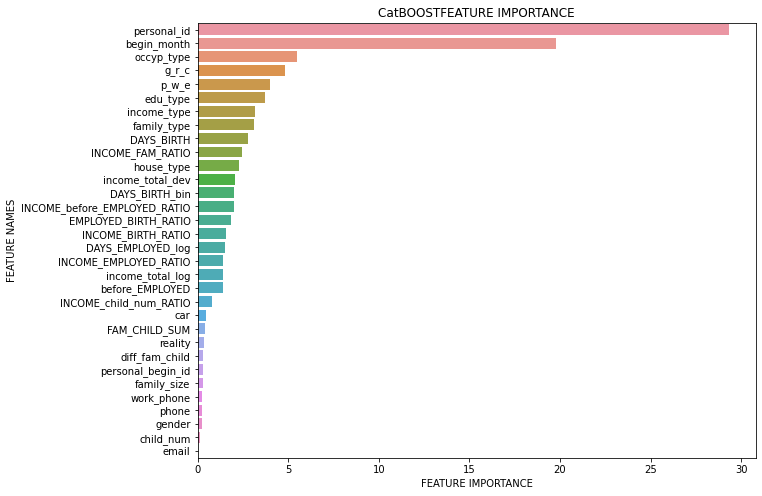

In [23]:
#plot the xgboost result
plot_feature_importance(cat_models[0].get_feature_importance(), train_x.columns,'CatBOOST')

# 최종 모델 fit 전체로 학습

In [ ]:
cat = CatBoostClassifier(n_estimators=440, max_depth=8, random_seed=2, learning_rate =0.04, bootstrap_type ='Bernoulli')
cat.fit(train_x, train_y, cat_features=cat_features, verbose=50)
test_predictions = cat.predict_proba(test)

0:	learn: 1.0757624	total: 110ms	remaining: 48.3s
50:	learn: 0.7395179	total: 4.59s	remaining: 35s
100:	learn: 0.7122598	total: 10.7s	remaining: 35.9s
150:	learn: 0.7035743	total: 17.3s	remaining: 33.1s
200:	learn: 0.6971476	total: 24.1s	remaining: 28.7s
250:	learn: 0.6911508	total: 30.8s	remaining: 23.2s
300:	learn: 0.6834176	total: 38s	remaining: 17.5s
350:	learn: 0.6765608	total: 45s	remaining: 11.4s
400:	learn: 0.6692687	total: 52.6s	remaining: 5.12s


# 결과 확인 및 제출 파일 생성

In [29]:
my_submission = test_predictions 
my_submission

array([[0.13825518, 0.17499774, 0.68674708],
       [0.34071298, 0.23721664, 0.42207038],
       [0.03983664, 0.07509341, 0.88506995],
       ...,
       [0.04653734, 0.11161226, 0.84185039],
       [0.14191861, 0.31761458, 0.5404668 ],
       [0.05479071, 0.4509871 , 0.49422219]])

In [30]:
# my_submission_mean = (my_submission1 + my_submission2 + my_submission3)/3
# my_submission_mean

In [31]:
submission=pd.read_csv('./open/sample_submission.csv')
submission.loc[:,1:]=my_submission
submission

,index,0,1,2
0,26457,0.138255,0.174998,0.686747
1,26458,0.340713,0.237217,0.422070
2,26459,0.039837,0.075093,0.885070
3,26460,0.063896,0.072631,0.863473
4,26461,0.077709,0.209775,0.712516
...,...,...,...,...
9995,36452,0.062743,0.206846,0.730411
9996,36453,0.134688,0.421674,0.443637
9997,36454,0.046537,0.111612,0.841850
9998,36455,0.141919,0.317615,0.540467


In [32]:
submission.to_csv('./submit/10fold_cat_0.66575_fit_440_0.66479.csv', index=False) 

In [33]:
submission.head(20)

,index,0,1,2
0,26457,0.138255,0.174998,0.686747
1,26458,0.340713,0.237217,0.422070
2,26459,0.039837,0.075093,0.885070
3,26460,0.063896,0.072631,0.863473
4,26461,0.077709,0.209775,0.712516
5,26462,0.055989,0.125951,0.818061
6,26463,0.647519,0.329222,0.023259
7,26464,0.044266,0.084067,0.871667
8,26465,0.056298,0.082324,0.861378
9,26466,0.059082,0.273524,0.667394
